In [230]:
import game_runner
import simple_agent
import llm_agent
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import make_prompt


In [231]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [232]:
def calculate_discounted_value(offer, values, gamma, round_num):
    """Calculate discounted value of an offer"""
    if offer is None:
        return 0
    base_value = sum(v * q for v, q in zip(values, offer))
    return base_value * (gamma ** (round_num - 1))


In [233]:
rounds = []
p1_values = []
p2_values = []
max_rounds = 10
p1_offers = []
p2_offers = []
game = game_runner.NegotitaionGame(
    player1_agent=llm_agent.LLMAgent(),
    player2_agent=llm_agent.LLMAgent(),
    num_items=4,
    item_value_range=[0, 101],
    gamma=0.9,
    max_rounds=max_rounds,
    outside_offer_value_range=[10000, 10001]
)

# Initialize tracking variables
rounds = []
p1_values = []
p2_values = []

# Run game step by step to track values
while game.in_progress:  
    current_step = len(game.history[0]) + len(game.history[1]) + 1
    current_round = (current_step - 1) // 2 + 1
    current_player = 1 if current_step % 2 == 1 else 2
    
    print(f"\n{'='*80}")
    print(f"Round {current_round}, Player {current_player}'s turn (Step {current_step})")
    print(f"{'='*80}")

    prev_offer = game.current_offer  
    game.step()  
    
    
    if game.current_offer:
        p1_kept = game.items - np.array(game.current_offer.offer)
        p1_value = calculate_discounted_value(p1_kept, game.player_values[0], game.gamma, current_round)
        p2_value = calculate_discounted_value(game.current_offer.offer, game.player_values[1], game.gamma, current_round)
        
        if current_player == 2:
            rounds.append(current_round)
            p1_values.append(p1_value)
            p2_values.append(p2_value)
            p1_offers.append(prev_offer.offer)  # Track Player 1's offer
            p2_offers.append(game.current_offer.offer)  # Track Player 2's offer
            print(f"\nRound {current_round} Values:")
            print(f"Player 1: {p1_value:.2f}")
            print(f"Player 2: {p2_value:.2f}")
    
    # If it's the last round and Player 2 just moved 
    if current_round == game.max_rounds and current_player == 2: 
        # Show Player 2's action
        if game.current_offer and game.current_offer != prev_offer:
            print(f"\nPlayer 2's final action: COUNTEROFFER {game.current_offer.offer}")
        elif game.current_offer == prev_offer:
            print("\nPlayer 2's final action: ACCEPT")
        else:
            print("\nPlayer 2's final action: WALK")
            
        # Now end with outside offers
        p1_value = game.outside_offer_values[0] * (game.gamma ** (current_round - 1))
        p2_value = game.outside_offer_values[1] * (game.gamma ** (current_round - 1))
        game.in_progress = False
        
        print("\nGame ended after max rounds - both players get outside offers")
        print(f"\nRound {current_round} Final Values:")
        print(f"Player 1: {p1_value:.2f}")
        print(f"Player 2: {p2_value:.2f}")
        
        # Add final values to tracking
        rounds.append(current_round)
        p1_values.append(p1_value)
        p2_values.append(p2_value)
        break




Round 1, Player 1's turn (Step 1)

    You and another agent have to negotiate a division of items between the two of you.
    You are Player 1 and the other agent is Player 2.
    There are 4 types of items, called item 1 through item 4.
    There are 4 units of item 1, 4 units of item 2, 4 units of item 3, 4 units of item 4 to divide.
    Both you and Player 2 have a private value per unit of each item type.
    These values are drawn from a uniform random distribution, ranging from 0 to 101.
    Your private values are 78 for item 1, 25 for item 2, 10 for item 3, 66 for item 4.
    Both you and Player 2 also have a private outside offer, of value drawn from a uniform random distribution, ranging from 10000 to 10001.
    Your outside offer value is 10000.

    The negotiation proceeds in 10 rounds.
    There is a discount rate gamma = 0.9, such that if the process concludes after r rounds the overall value of the negotiation to each player is their value for the outcome multiplied b

## Discounted Values Over Time

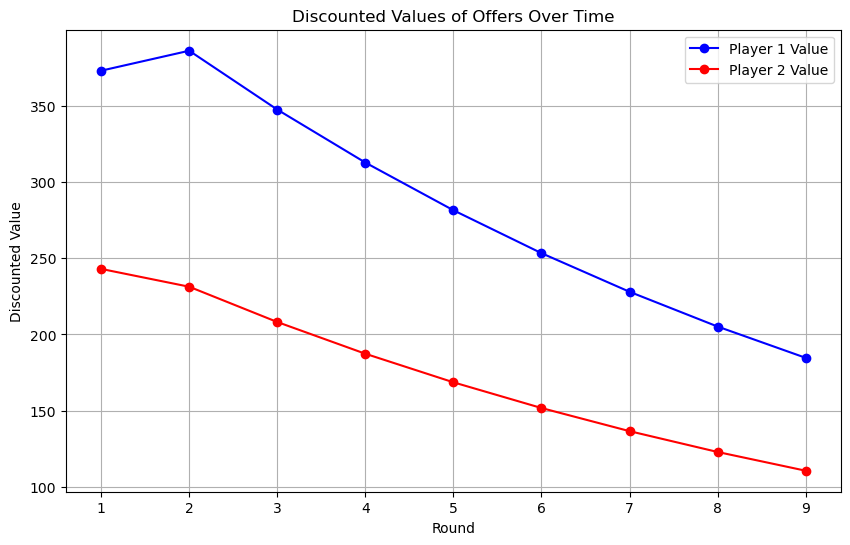


Final Values:
Player 1: 184.67
Player 2: 110.63


In [234]:
plt.figure(figsize=(10, 6))
plt.plot(rounds, p1_values, 'b-o', label='Player 1 Value')
plt.plot(rounds, p2_values, 'r-o', label='Player 2 Value')
plt.xlabel('Round')
plt.xticks(range(1, max(rounds)+1))
plt.ylabel('Discounted Value')
plt.title('Discounted Values of Offers Over Time')
plt.legend()
plt.grid(True)
plt.show()

if game.current_offer:
    print(f"\nFinal Values:")
    print(f"Player 1: {p1_values[-1]:.2f}")
    print(f"Player 2: {p2_values[-1]:.2f}")

## Offer Evolution

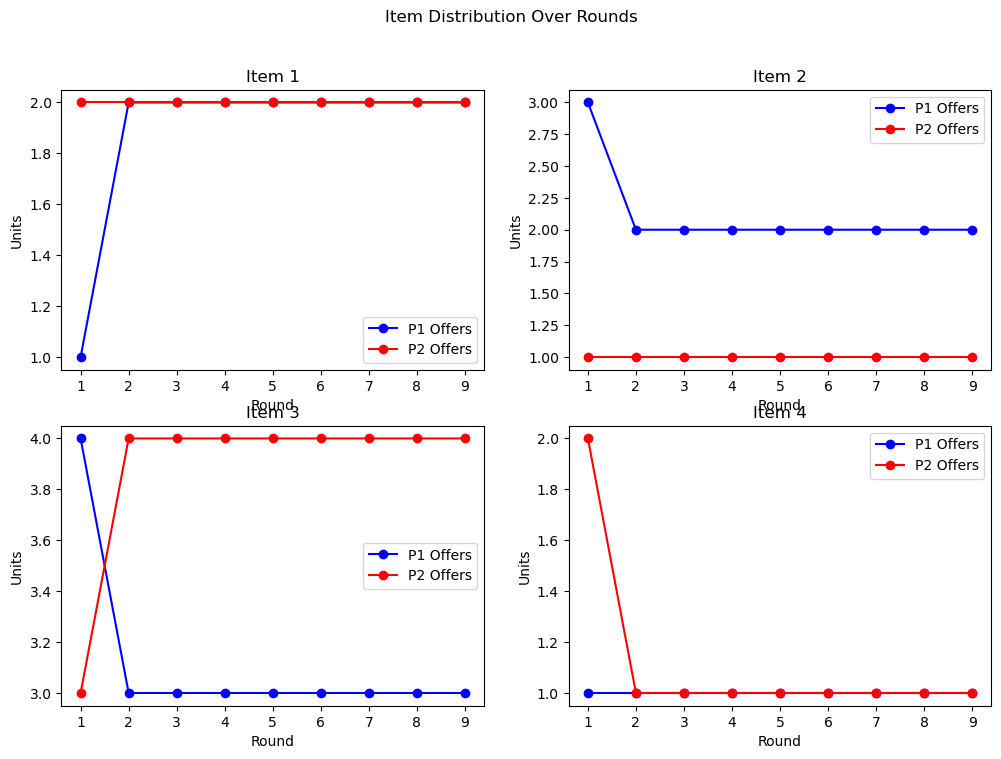

In [235]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Item Distribution Over Rounds')

# Use only the rounds where we have offers
valid_rounds = rounds[:len(p1_offers)]  # Since p1_offers and p2_offers have same length

for i in range(game.num_items):
    row = i // 2
    col = i % 2
    axs[row, col].plot(valid_rounds, [h[i] for h in p1_offers], 'b-o', label='P1 Offers')
    axs[row, col].plot(valid_rounds, [h[i] for h in p2_offers], 'r-o', label='P2 Offers')
    axs[row, col].set_title(f'Item {i+1}')
    axs[row, col].set_xlabel('Round')
    axs[row, col].set_ylabel('Units')
    axs[row, col].set_xticks(range(1, max(valid_rounds) + 1))
    axs[row, col].legend()


## Negotiation Gap

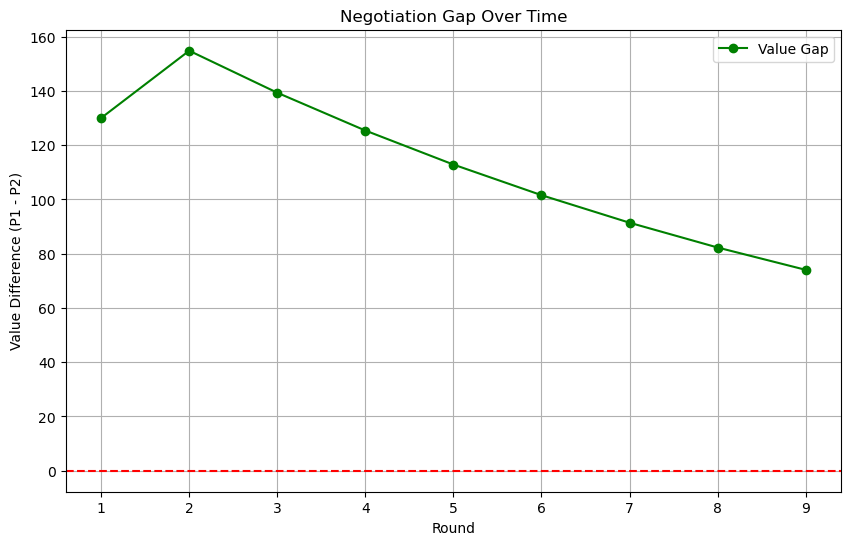

In [236]:
plt.figure(figsize=(10, 6))
value_gaps = [p1 - p2 for p1, p2 in zip(p1_values, p2_values)]
plt.plot(rounds, value_gaps, 'g-o', label='Value Gap')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Round')
plt.ylabel('Value Difference (P1 - P2)')
plt.title('Negotiation Gap Over Time')
plt.xticks(range(1, max(rounds)+1))  # Set x-axis ticks separately
plt.legend()
plt.grid(True)
plt.show()

## Basic Fairness



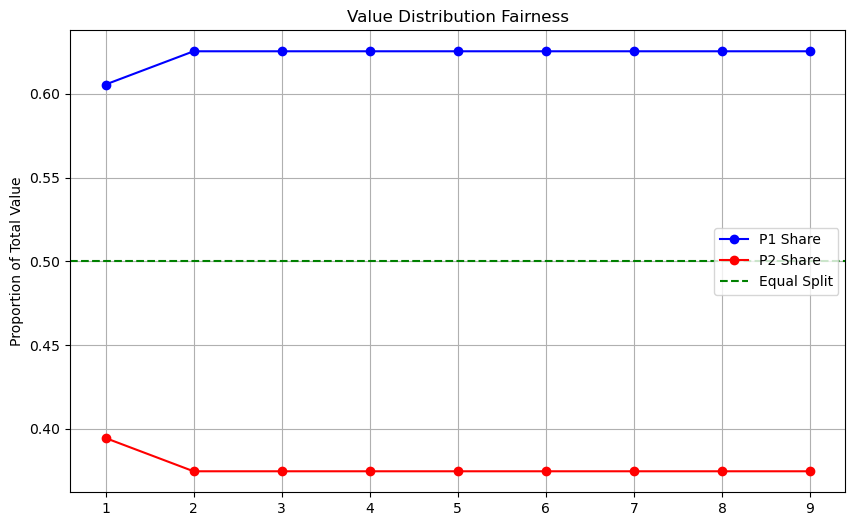

In [237]:
plt.figure(figsize=(10, 6))
fairness = [(p1/(p1+p2), p2/(p1+p2)) for p1, p2 in zip(p1_values, p2_values)]
plt.plot(rounds, [f[0] for f in fairness], 'b-o', label='P1 Share')
plt.plot(rounds, [f[1] for f in fairness], 'r-o', label='P2 Share')
plt.axhline(y=0.5, color='g', linestyle='--', label='Equal Split')
plt.ylabel('Proportion of Total Value')
plt.xticks(range(1, max(rounds)+1)) 

plt.title('Value Distribution Fairness')
plt.legend()
plt.grid(True)
plt.show()

## Discount Impact

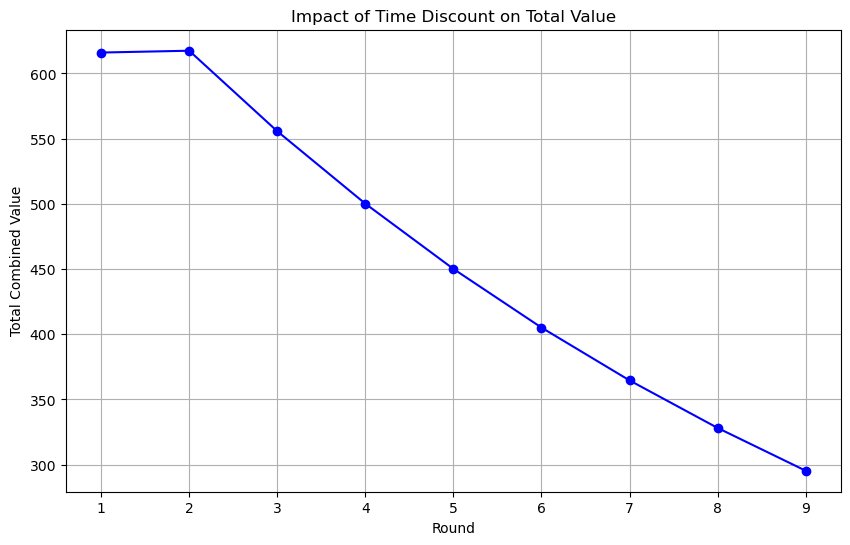

In [238]:
plt.figure(figsize=(10, 6))
total_values = [p1 + p2 for p1, p2 in zip(p1_values, p2_values)]
plt.plot(rounds, total_values, 'b-o')
plt.xlabel('Round')
plt.xticks(range(1, max(rounds)+1))  # Set x-axis ticks separately

plt.ylabel('Total Combined Value')
plt.title('Impact of Time Discount on Total Value')
plt.grid(True)
plt.show()